# Advanced Machine Learning 3rd Project
### Authors: Guilherme Cepeda - 62931, Pedro Serrano - 54853


In this third assignment, we were asked to apply reinforcement learning to the Mountain Cart problem, from Gymnasium. We will split this in two parts, one where we implement Q-Learning, and one where we implement Deep Q-Learning, as requested in the statement.

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings as w
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import shapiro

import gymnasium as gym
import pickle

### Load Data 

For the **Mountain Car reinforcemet learning problem** the challenge lies in the continuous control problem of getting the car to move uphill by applying appropriate forces. There's no randomness in the transitions between states in the same way as it might be in a discrete grid world like FrozenLake. 

In [2]:
env = gym.make('MountainCar-v0', render_mode="rgb_array") # rendered to an rbg array, returned as a NumPy array containing pixel values
#env = gym.make('MountainCar-v0', render_mode="human") #  will be rendered in a window or on the screen using the standard rendering mechanism (GUI) of the system

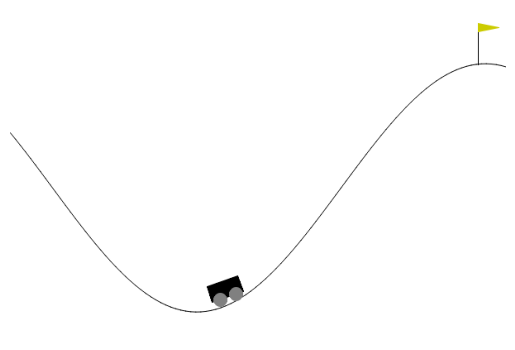

In [3]:
env.reset()
plt.imshow(env.render())
plt.axis('off')
plt.show()

### Exploratory Data Analysis (EDA)

First we started by understanding the possible states and actions of the environment.


Acho que esta parte podia ser so apagada tbh, never eu sei o que e que vais dizer mas aqui e para demonstrar que fomos verificar os states e actions e apresentamos so para termos o caminho completo.

#### States


In [10]:
env.observation_space #Position of the car along the x-axis, Min: -1.2 Max: 0.6
                      #Velocity of the car, Min:-0.07 Max: 0.07

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

In [76]:
env.observation_space.high[0]

0.6

#### Actions

3 actions:
* Drive left
* Stay neutral
* Drive right

In [11]:
print(env.action_space) 
print("\n",env.action_space.n)

Discrete(3)

 3


In [75]:
env.action_space.sample() # generates a random action sample between 0(left), 1 (neutral) and 2(right)


0

In [60]:
env.step(env.action_space.sample())# executes an action

(array([-0.5742453 ,  0.00311769], dtype=float32), -1.0, False, False, {})

### Q - Learning

The Q-Learning algorithm is an model-free, off-policy method of doing Reinforcement Learning. This means we will not be estimating the transition matrix and the rewards, and will be going straight after an optimal policy.

How do we do this?
We create a Q-table, which is a lookup table os (os ANTERIOR VERIFICAR QUAL ERA O MEANING) states by actions, where, in each entry [state[i], action[i]] we have stored the optimal policy for that specific request. We estimate each Q value as the sum of the immediate reward, plus the maximum Q value of the possible future actions. We usualy add a weight - the discount factor - to this second part to balance out how much we want to reward the current reward. We expect the optimal discount factor in this problem to be fairly high - its like this is most cases, we believe.

As presented in the statement, the space is continuous, so we will need to turn it into a discrete space. 

We use the numpy linspace function to separate the entire range of the position and velocity scalers in equal parts. Here we initilly picked 5 (yes, it was very small), and tested bigger and bigger numbers until reaching the optimum value.



Here is where we initialize some of the models parameters

The Q-table starts off by all zeros - we also tested by starting with random numbers, but it didnt improve (later we realized this was useless, since we were starting our epsilon at 1)

The treshold is an alternitive to having a fixed number of episodes - instead we pick a very low treshold, and if we dont improve more than the threshold, we stop running.

We have talked about the discount factor before, but here we also initizalize the learning rate - still dont know what this is specifically.

We start our epsilon at 1, and keep decreasing with every episode. The epsilon gives our how much of our decision is going to be random, meaning we start off with a completely random decision, and make them less random with every episode by using our Q-table

The rewards per episode is just an array, initialized at all zeros, where we will be updating our rewards.

In [4]:
def q_learning_test(training, episodes):

    # Divide position and velocity into segments
    position_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 20)    # position between -1.2 and 0.6
    velocity_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 20)    # velocity between -0.07 and 0.07

    if(training):
        #if we are training, we begin with an empty Q-table. Alternitivly, we can initialize random numbers
        q_table = np.zeros((len(position_space), len(velocity_space), env.action_space.n)) # initialize the q table with dimension 20x20x3
    else:
        #Otherwise, we just load the last updated Q-table from the traiinng phase
        f = open('mountain_car.pkl', 'rb')
        q_table = pickle.load(f)
        f.close()

    #set the threshold number for checking the convergence of the value function
    threshold = 1e-10 # 1e-20 no effect on the episodes
                     # 1e-5 the graph becomes mostly straight and destroys the test no longer works so threshold > 1e-5

    alpha = 0.9 # alpha = learning rate
    gamma = 0.9 # gamma = discount factor

    epsilon = 1 # 100% random actions
    #epsilon_decay_rate = 2/episodes # epsilon decay rate
    epsilon_decay_rate = 0.99975

    random_n_g = np.random.default_rng()   # random number generator

    rewards_per_episode = np.zeros(episodes) # rewards per episode

    for i in range(episodes):

        state = env.reset()[0]      # Starting position, starting velocity always 0
        state_p = np.digitize(state[0], position_space)
        state_v = np.digitize(state[1], velocity_space)

        terminated = False # when terminated is true it means we reached our goal

        rewards = 0 # each reward is -1

        previous_q_table = np.copy(q_table)  # Copy of the Q-table from the previous episode

        while(not terminated and rewards>-1000):

            if training and random_n_g.random() < epsilon:
                # Choose random action (0=drive left, 1=stay neutral, 2=drive right)
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state_p, state_v, :]) # finds the index of the action that has the highest Q-value for the specified state in the Q-values array

            new_state,reward,terminated,_,_ = env.step(action)
            
            new_state_p = np.digitize(new_state[0], position_space)
            new_state_v = np.digitize(new_state[1], velocity_space)

            if training:
                q_table[state_p, state_v, action] = q_table[state_p, state_v, action] + alpha * (
                    reward + gamma *np.max(q_table[new_state_p, new_state_v,:]) - q_table[state_p, state_v, action]
                )

            state = new_state
            state_p = new_state_p
            state_v = new_state_v

            rewards+=reward

        #epsilon = max(epsilon - epsilon_decay_rate, 0)
        if epsilon > 0.001:
            epsilon *= epsilon_decay_rate 
        else:
            epsilon = 0.001

        rewards_per_episode[i] = rewards

        # Check for convergence based on the change in Q-values
        if training and i > 0:
            q_change = np.mean(np.abs(q_table - previous_q_table))
            if q_change < threshold:
                print(f"Convergence reached. Stopping at episode {i}.")
                break
            previous_q_table = np.copy(q_table)

    env.close()

    # Save Q table to file
    if training:
        f = open('mountain_car.pkl','wb')
        pickle.dump(q_table, f)
        f.close()


    #Plot the results
    mean_rewards = np.zeros(episodes)
    for t in range(episodes):
        mean_rewards[t] = np.mean(rewards_per_episode[max(0, t-100):(t+1)]) #  technique to smooth out fluctuations in the learning curve to provide a more stable measure of the agent's performance over time.
    plt.plot(mean_rewards)
    plt.savefig(f'mountain_car.png')


In [ ]:
plt.imshow(env.render())
plt.axis('off')
plt.show()

Below, we show a plot, displaying how the rewards improve with the episodes.

We can see its learning, and then stops at a little over -200. Why is the number negative? We dont assign a reward to finishing, and we decrease our reward for every step - this is to make the algorithm choose faster paths, meaning our car took a little less than 200 steps to get to the top.

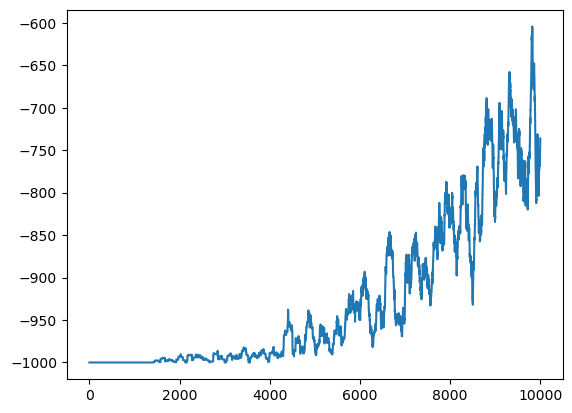

In [6]:
#training
q_learning_test(True,10000)

Before, we were just training the model. Now, lets test how good our Q-table really is. 

Here, we use the gym package to render the GUI, and do the same plot we did before, but this time, since the values are close together, we can cleary see we get a maximum of -145, meaning we can get our car to the top with 145 steps.

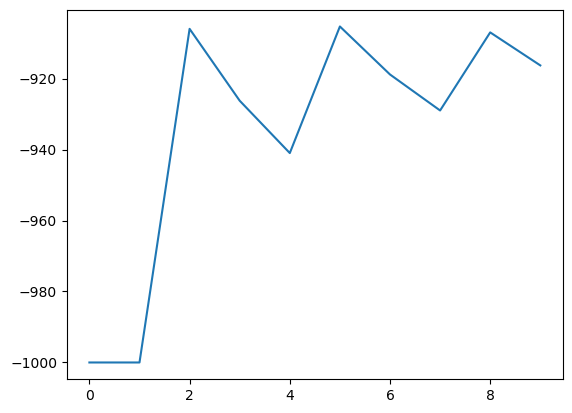

In [8]:

env = gym.make('MountainCar-v0') 
#test
q_learning_test(False, 10)

 * CHECK IF EPOCHS ARE NEEDED 
 * test cycle with threshold for restraining the number of episodes, THRESHOLD DOESNT SEEM NECESSARY OR DOES NOT IMPROVE THE RESULTS WHE APPLIED

## Deep Q-Learning